In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# -N? Đọc ảnh

In [3]:
img = Image.open('lena.png')
img_2d = np.array(img)

# 1. Thay đổi độ sáng cho ảnh 

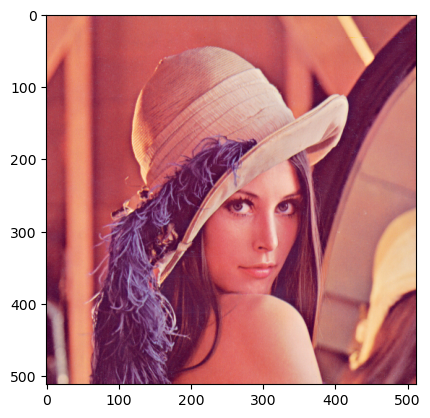

In [11]:
def truncate(value):
    return 0 if value < 0 else 255 if value > 255 else value.astype('uint8')

In [12]:
def change_brightness(img_2d, brightness):
    # broadcasting
    img_2d = img_2d + brightness
    img_2d = truncate(img_2d[i] for i in img_2d)

In [13]:
new_img_2d = change_brightness(img_2d, 100)
plt.imshow(new_img_2d)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# 2. Thay đổi độ tương phản của ảnh

# 3. Lật ảnh ngang dọc

In [6]:
def flip_image(img_2d, axis):
    # Horizontal
    if axis == 0:
        return img_2d[::-1, :]
    # Vertical
    elif axis == 1:
        return img_2d[:, ::-1]

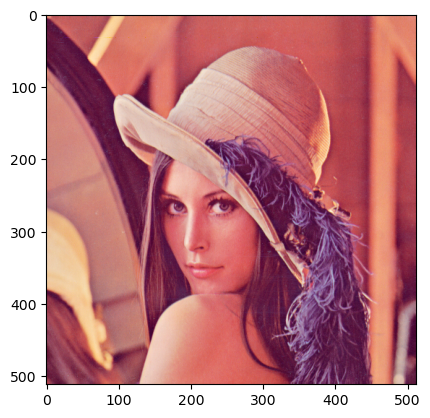

In [10]:
plt.imshow(flip_image(img_2d, 0))
plt.imshow(flip_image(img_2d, 1))